In [211]:
import os
import warnings
import pathlib
from typing import List
import glob

from alpineer import io_utils
from skimage import io
from tqdm.notebook import tqdm
from ark.utils import deepcell_service_utils, plot_utils
from ark.segmentation import marker_quantification, segmentation_utils

import numpy as np 
from matplotlib import pyplot as plt
from PIL import Image

from pyometiff import OMETIFFReader,OMETIFFWriter
import tifffile as tiff
from skimage.transform import resize


In [212]:
base_dir = "data_processing"
ome_dir_path: str = "data_processing/raw_image_data"
data_dir_path: str = "data_processing/fov_split_data"

data_dir = pathlib.Path(data_dir_path)
ome_dir: str = pathlib.Path(ome_dir_path)

# Make the paths if they do not exist
data_dir.mkdir(parents=True, exist_ok=True)
ome_dir.mkdir(parents=True, exist_ok=True)

In [213]:
# set up file paths
tiff_dir = os.path.join(base_dir, "fov_split_data")
cell_table_dir = os.path.join(base_dir, "segmentation/cell_table")
deepcell_input_dir = os.path.join(base_dir, "segmentation/deepcell_input")
deepcell_output_dir = os.path.join(base_dir, "segmentation/deepcell_output")
deepcell_visualization_dir = os.path.join(base_dir, "segmentation/deepcell_visualization")

In [214]:
# create directories if do not exist
for directory in [cell_table_dir, deepcell_input_dir, deepcell_output_dir, deepcell_visualization_dir]:
    if not os.path.exists(directory):
        os.makedirs(directory)

In [215]:
io_utils.validate_paths([base_dir,
                         tiff_dir,
                         deepcell_input_dir,
                         deepcell_output_dir,
                         cell_table_dir,
                         deepcell_visualization_dir
                         ])

In [216]:
# Gather all the OME-TIFFs in list
ome_tiffs = list(ome_dir.glob("*.ome.[tif tiff]*"))
image_data = []

# Convert all the OME-TIFFs to Single Channel TIFFs
for ome_tiff in tqdm(ome_tiffs):
    img_fpath = pathlib.Path(ome_tiff)
    reader = OMETIFFReader(fpath=img_fpath)
    img_array, metadata, xml_metadata = reader.read()
    #Add Indidial Tiff images to dataset 
    temp = []
    for image in img_array:
        temp.append(image)
    #image_data.append(((resize(img_array[5], (512, 512))),(resize(img_array[7], (512, 512))),(resize(img_array[0], (512, 512)))))
    image_data.append(temp)


    

  0%|          | 0/1 [00:00<?, ?it/s]

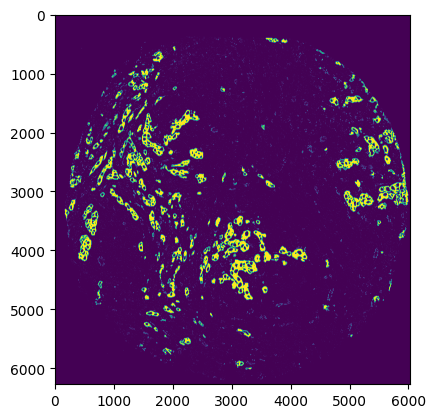

In [217]:
plt.imshow(image_data[0][5])

In [218]:
for i in range(len(ome_tiffs)):
    if not os.path.exists(f"data_processing/fov_split_data/fov{i}"):
        os.makedirs(f"data_processing/fov_split_data/fov{i}")

In [219]:
markers = ["Nuclear","CD31","CK5","SMA","Ki67","CK8","ANAX1","E-Cadherin","Pericentrin","C-Caspase-3","Nulcear-Day-9"]

In [220]:
for i in range(len(ome_tiffs)):
    for images in image_data:
        count = 0
        for stain_images in images:
            tiff.imwrite(f"data_processing/fov_split_data/fov{i}/{markers[count]}.tiff",resize(stain_images,(512, 512)))
            count += 1
    

In [221]:
fovs = io_utils.list_folders(tiff_dir)

In [222]:
# NOTE: at least one of nucs and mems must not be None
# nuclear channel name(s) (or nucs = None)
nucs = ['Nuclear']

# membrane channel name(s) (or mems = None)
mems = ['E-Cadherin', 'CK8']

In [223]:
deepcell_service_utils.generate_deepcell_input(
    deepcell_input_dir,
    tiff_dir,
    nucs,
    mems,
    fovs,
    img_sub_folder=None
)

In [224]:
rescale_factor = 1.0
deepcell_service_utils.create_deepcell_output(deepcell_input_dir, deepcell_output_dir, fovs=fovs, scale=rescale_factor)

Processing tiffs in 1 batches...
Segmentation progress for batch_1:


  0%|          | 0/100 [00:00<?]

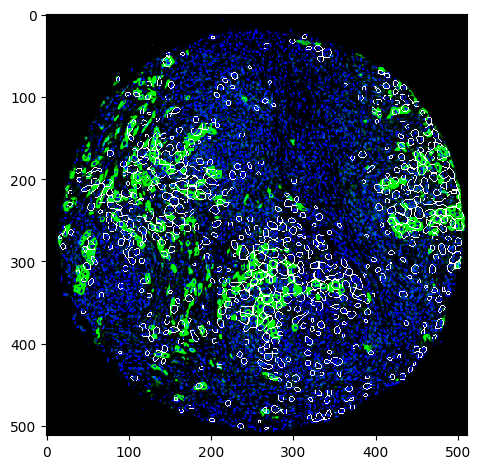

In [225]:
# display the channel overlay for a fov, useful for quick verification
warnings.simplefilter("ignore")

fov_to_display = io_utils.remove_file_extensions([fovs[0]])[0]

fov_overlay = plot_utils.create_overlay(
    fov=fov_to_display,
    segmentation_dir=deepcell_output_dir,
    data_dir=deepcell_input_dir,
    img_overlay_chans=['nuclear_channel', 'membrane_channel'],
    seg_overlay_comp='whole_cell'
)

_ = io.imshow(fov_overlay)

In [226]:
# save the overlaid segmentation labels for each fov (these will not display, but will save in viz_dir)
segmentation_utils.save_segmentation_labels(
    segmentation_dir=deepcell_output_dir,
    data_dir=deepcell_input_dir,
    output_dir=deepcell_visualization_dir,
    fovs=io_utils.remove_file_extensions(fovs),
    channels=['nuclear_channel', 'membrane_channel']
)

In [227]:
# set to True to add nuclear cell properties to the expression matrix
nuclear_counts = True

# set to True to bypass expensive cell property calculations
# only cell label, size, and centroid will be extracted if True
fast_extraction = False

In [228]:
# now extract the segmented imaging data to create normalized and transformed expression matrices
# note that if you're loading your own dataset, please make sure all the imaging data is in the same folder
# with each fov given its own folder and all fovs having the same channels
cell_table_size_normalized, cell_table_arcsinh_transformed = \
    marker_quantification.generate_cell_table(segmentation_dir=deepcell_output_dir,
                                              tiff_dir=tiff_dir,
                                              img_sub_folder=None,
                                              fovs=fovs,
                                              batch_size=5,
                                              nuclear_counts=nuclear_counts,
                                              fast_extraction=fast_extraction)

extracting data from fov0
extracting data from fov1


In [229]:
# Set the compression level if desired, ZSTD compression can offer up to a 60-70% reduction in file size.
# NOTE: Compressed `csv` files cannot be opened in Excel. They must be uncompressed beforehand.
compression = None

# Uncomment the line below to allow for compressed `csv` files.
# compression = {"method": "zstd", "level": 3}

cell_table_size_normalized.to_csv(os.path.join(cell_table_dir, 'cell_table_size_normalized.csv'),
                                  compression=compression, index=False)
cell_table_arcsinh_transformed.to_csv(os.path.join(cell_table_dir, 'cell_table_arcsinh_transformed.csv'),
                                      compression=compression, index=False)